In [1]:
from tensorflow.keras import models
from tensorflow.keras.layers import Activation, ZeroPadding2D, MaxPooling2D, Conv2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers, constraints
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('data/umist_cropped_with_cluster_id_training.csv')
val_data = pd.read_csv(r'data\validation_data\umist_cropped_with_cluster_id_val.csv')
test_data = pd.read_csv('data/test_data/umist_cropped_with_cluster_id_test.csv')

In [3]:
X_train = data.drop(['cluster_id'],axis = 1)
y_train = data['cluster_id']

X_val = val_data.drop(['cluster_id'],axis = 1)
y_val = val_data['cluster_id']

X_test = test_data.drop(['cluster_id'],axis = 1)
y_test = test_data['cluster_id']

In [4]:
print(type(X_train))

<class 'pandas.core.frame.DataFrame'>


In [5]:
# Extract pixel values and reshape
X_train = X_train.values.reshape(-1, 112, 92, 1)

X_val = X_val.values.reshape(-1, 112, 92, 1)

X_test = X_test.values.reshape(-1, 112, 92, 1)

In [6]:
# Normalize the images
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [7]:
IMAGE_WIDTH = 112
IMAGE_HEIGHT = 92
NUM_CLASSES = np.unique(y_train).shape[0]
BATCH_SIZE = 32
EPOCHS = 20
NUMBER_OF_TRAINING_IMAGES = 600

In [8]:
model = models.Sequential()

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1), padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2=0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2=0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu', kernel_initializer="glorot_uniform", kernel_regularizer=regularizers.l2(l2=0.01)))

model.add(Dropout(0.5))

model.add(Dense(NUM_CLASSES, activation='softmax', kernel_initializer="glorot_uniform"))

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 112, 92, 512)   │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 46, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 54, 44, 128)    │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 27, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 20, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,932,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │        12,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,613,848 (17.60 MB)

 Trainable params: 4,613,848 (17.60 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='auto',
)

model_checkpoint = ModelCheckpoint(
    filepath='models/classifier/best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
)


In [11]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0003),
    metrics=["accuracy"]
)

In [12]:
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.0460 - loss: 14.1899
Epoch 1: val_accuracy improved from -inf to 0.09735, saving model to models/classifier/best_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 612ms/step - accuracy: 0.0465 - loss: 14.1233 - val_accuracy: 0.0973 - val_loss: 10.0712
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.1105 - loss: 9.1358
Epoch 2: val_accuracy improved from 0.09735 to 0.35398, saving model to models/classifier/best_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 617ms/step - accuracy: 0.1119 - loss: 9.0955 - val_accuracy: 0.3540 - val_loss: 6.4647
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.2479 - loss: 6.0633
Epoch 3: val_accuracy improved from 0.35398 to 0.58407, saving model to models/classifier/best_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 627ms/step - accuracy: 0.2516 - loss: 6.0346 - val_accuracy: 0.5841 - val_loss: 4.0358
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.4

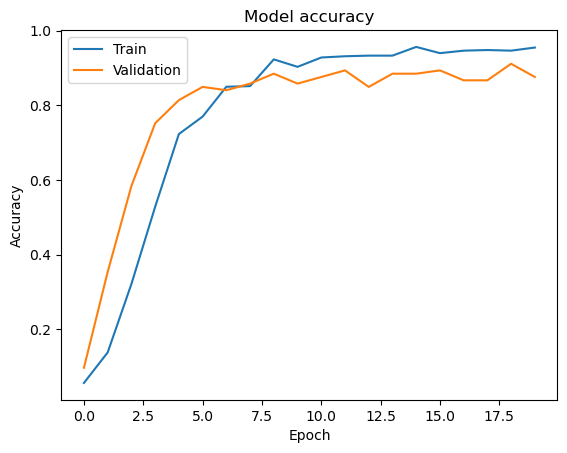

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

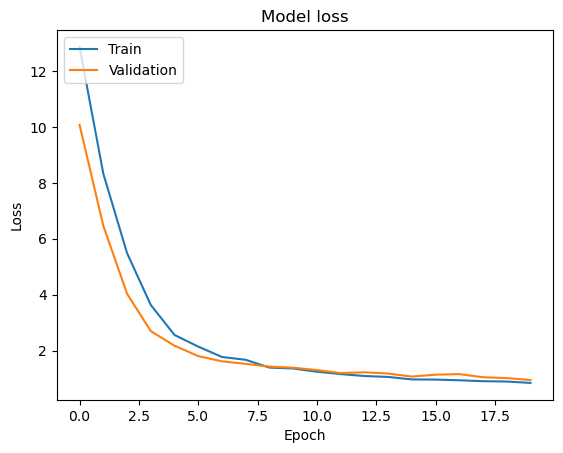

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [15]:
best_model = models.load_model('models/classifier/best_model.keras')

In [16]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.8840 - loss: 1.0664
Test loss: 1.2025160789489746
Test accuracy: 0.8584070801734924


In [17]:
y_test_pred = best_model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


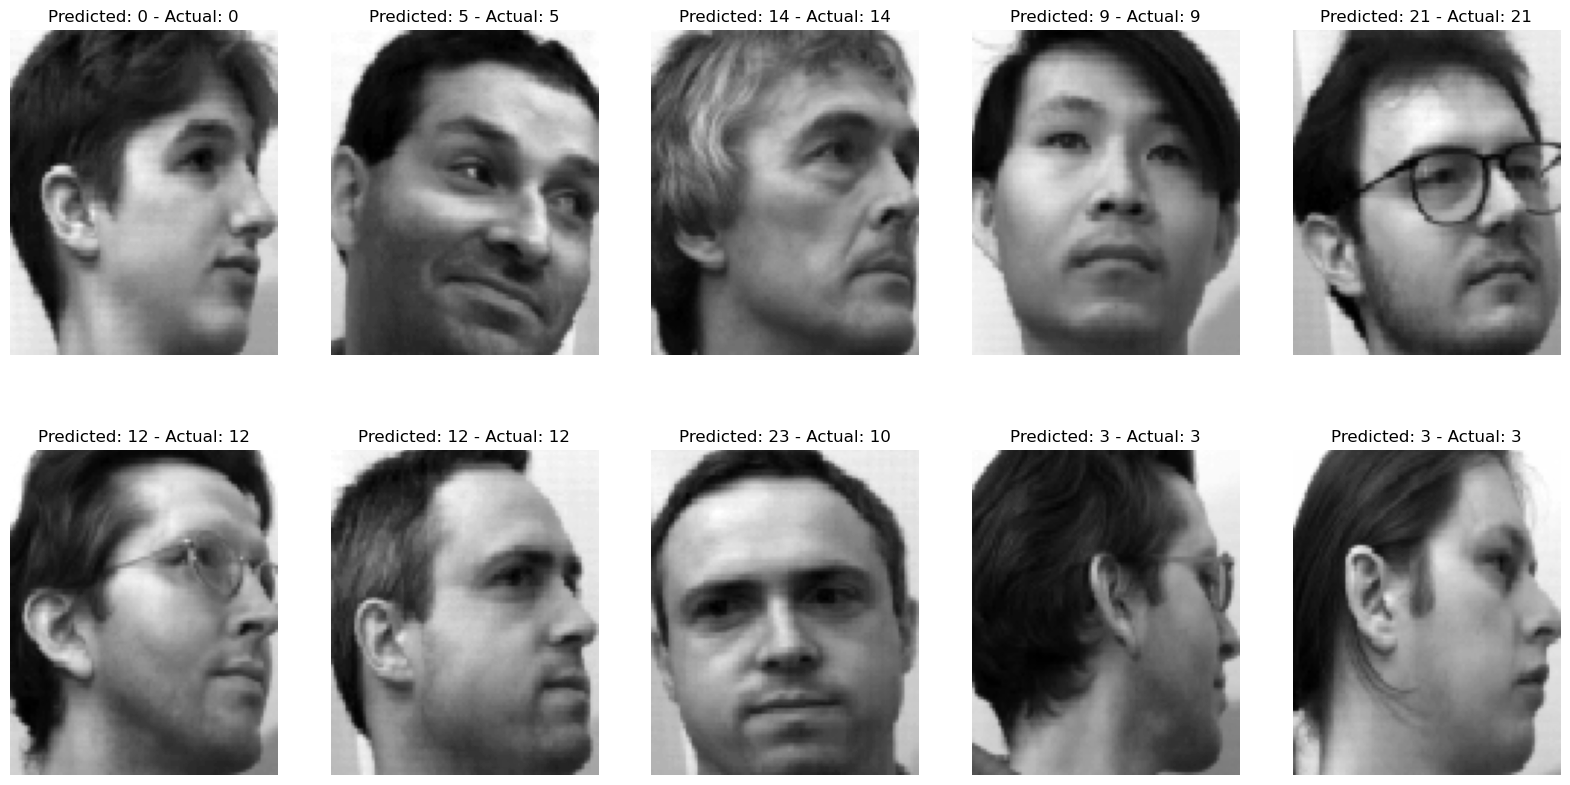

In [18]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))

for i in range(10):
    ax[i // 5, i % 5].imshow(X_test[i].reshape(112, 92), cmap='gray')
    ax[i // 5, i % 5].set_title(f"Predicted: {np.argmax(y_test_pred[i])} - Actual: {y_test[i]}")
    ax[i // 5, i % 5].axis('off')

plt.show()

In [19]:
for i in range(X_test.shape[0]):
    print(f"Predicted: {np.argmax(y_test_pred[i])} - Actual: {y_test[i]}")

Predicted: 0 - Actual: 0
Predicted: 5 - Actual: 5
Predicted: 14 - Actual: 14
Predicted: 9 - Actual: 9
Predicted: 21 - Actual: 21
Predicted: 12 - Actual: 12
Predicted: 12 - Actual: 12
Predicted: 23 - Actual: 10
Predicted: 3 - Actual: 3
Predicted: 3 - Actual: 3
Predicted: 15 - Actual: 15
Predicted: 9 - Actual: 9
Predicted: 11 - Actual: 11
Predicted: 4 - Actual: 4
Predicted: 22 - Actual: 22
Predicted: 11 - Actual: 11
Predicted: 14 - Actual: 14
Predicted: 12 - Actual: 12
Predicted: 8 - Actual: 8
Predicted: 4 - Actual: 4
Predicted: 8 - Actual: 8
Predicted: 23 - Actual: 23
Predicted: 5 - Actual: 5
Predicted: 11 - Actual: 11
Predicted: 0 - Actual: 0
Predicted: 7 - Actual: 7
Predicted: 3 - Actual: 3
Predicted: 11 - Actual: 11
Predicted: 18 - Actual: 18
Predicted: 14 - Actual: 14
Predicted: 11 - Actual: 11
Predicted: 6 - Actual: 12
Predicted: 0 - Actual: 0
Predicted: 4 - Actual: 15
Predicted: 15 - Actual: 15
Predicted: 20 - Actual: 20
Predicted: 8 - Actual: 8
Predicted: 7 - Actual: 7
Predicted:

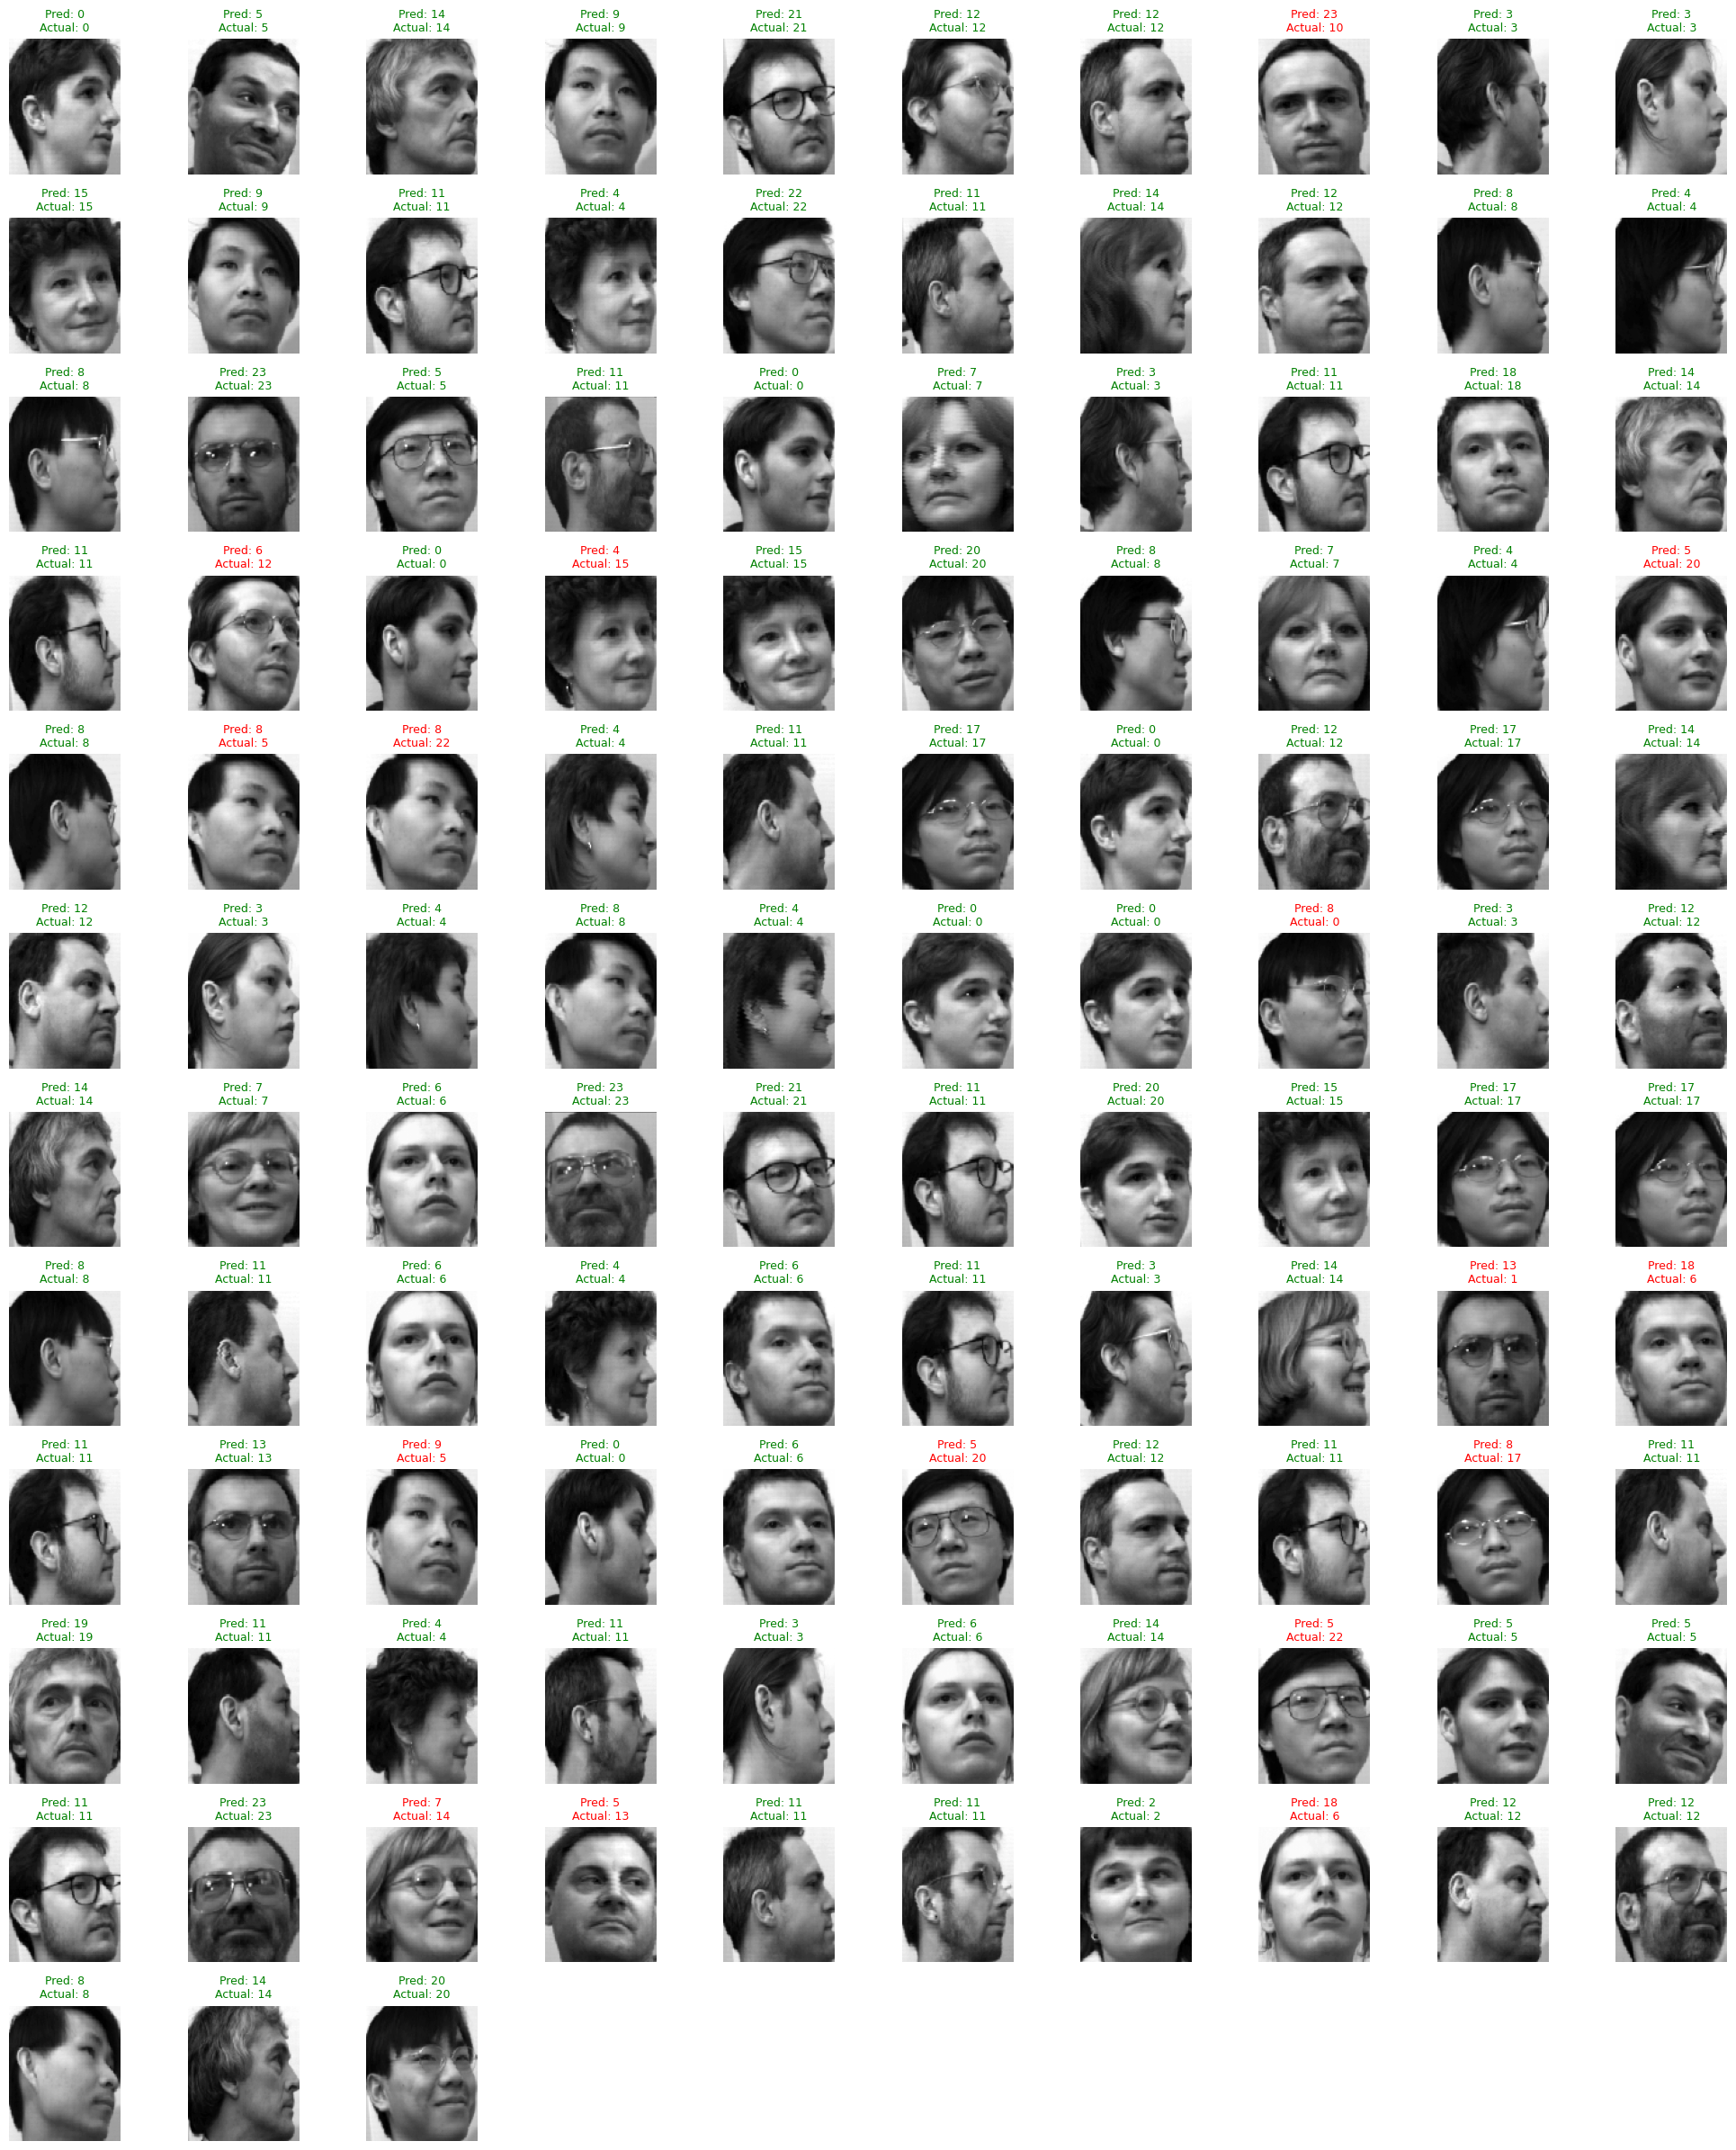

In [45]:
import matplotlib.pyplot as plt
import numpy as np

num_images = X_test.shape[0]
cols = 10  # Set number of columns to 10
rows = (num_images + cols - 1) // cols  # Calculate number of rows needed for 10 columns

fig, ax = plt.subplots(rows, cols, figsize=(20, rows * 2))  # Dynamic grid size
ax = ax.flatten()  # Flatten the axis array for easier indexing

mismatch_color = "red"
match_color = "green"

for i in range(num_images):
    ax[i].imshow(X_test[i].reshape(112, 92), cmap='gray')
    title_color = match_color if np.argmax(y_test_pred[i]) == y_test[i] else mismatch_color
    ax[i].set_title(f"Pred: {np.argmax(y_test_pred[i])}\nActual: {y_test[i]}", color=title_color, fontsize=9)
    ax[i].axis('off')

# Turn off any unused axes
for j in range(num_images, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()



In [22]:
X_test.shape[0]

113